I computed realizations of multiple HODs for a few statistics in the darksky boxes. This notebook is gonna combine them into a jackknife covmat. It'll also add some estimate of the shape noise contribution. 

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [3]:
import numpy as np
from glob import glob
from os import path

In [4]:
#shape_noise_covmat = np.load('/home/users/swmclau2/Git/pearce/bin/covmat/shape_noise_covmat.npy')
shape_noise_covmat = np.load('/home/users/swmclau2/Git/Public-code/Hankel_transform/shape_noise.npy')

In [5]:
print np.sqrt(np.diag(shape_noise_covmat))

[0.13828733 0.27572665 0.34334649 0.30256011 0.25836501 0.20140553
 0.15805671 0.12274955 0.08874209 0.06540262 0.04885425 0.03685824
 0.02818886 0.02205612 0.01778106 0.01473463 0.0124219  0.01056936]


In [6]:
output_dir = '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat_v2/'

In [7]:
outputs = sorted(glob(path.join(output_dir, 'wp_ds_cic_darksky_obs_???_v2.npy')))
print len(outputs)

512


In [8]:
N = len(outputs) # Should be 512, but a few may not have finished. Should make sure that those get reestarted, but likely not super important
all_outputs = np.zeros((N, 5,  2*18 + 14)) # num bins and num HODs 

In [9]:
2*18+14

50

In [10]:
for i,output_file in enumerate(outputs):
    output = np.load(output_file)

    all_outputs[i] = output#.mean(axis = 0)

In [11]:
all_outputs.shape

(512, 5, 50)

In [12]:
rp_bins = np.logspace(-1.0, 1.6, 19)
cic_bins = np.round(np.r_[np.linspace(1, 9, 8), np.round(np.logspace(1,2, 7))] )

In [13]:
cic_bins

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  15.,  22.,
        32.,  46.,  68., 100.])

In [14]:
rp_points = (rp_bins[1:]+rp_bins[:-1])/2.0
cic_points = (cic_bins[1:]+cic_bins[:-1])/2.0

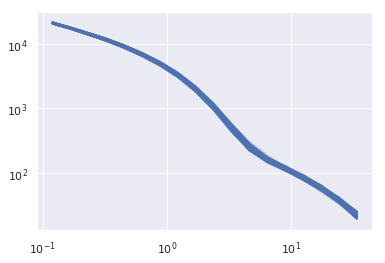

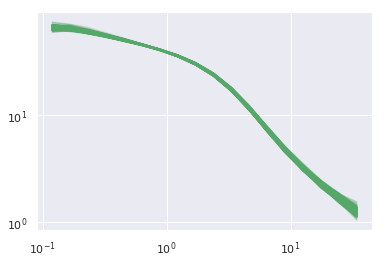

In [15]:
hod_idx = 4
plt.plot(rp_points, (all_outputs[:,hod_idx, :18]).T, alpha = 0.3, color = 'b')
plt.loglog();
plt.show();
plt.plot(rp_points, (all_outputs[:,hod_idx, 18:36]).T, alpha = 0.3, color = 'g')
plt.loglog();
plt.show();
#plt.plot(cic_points, all_outputs[idx, 36:])
#plt.loglog();
#plt.show();

In [16]:
mean = all_outputs.mean(axis = 0)

In [17]:
R =(all_outputs - mean)

cov = np.zeros((R.shape[2], R.shape[2]))
for i in xrange(R.shape[1]):
    cov+= R[:,i].T.dot(R[:,i])/(N-1)
    
cov/=R.shape[1]

In [18]:
cov.shape

(50, 50)

In [19]:
np.min(cov)

-60.129559519423864

In [20]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

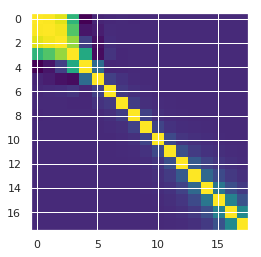

In [21]:
plt.imshow(cov_to_corr(shape_noise_covmat), cmap = 'viridis')

In [22]:
print(cov_to_corr(shape_noise_covmat))[:5, :5]

[[ 1.          0.99288521  0.94697345  0.60691206 -0.13365605]
 [ 0.99288521  1.          0.97837507  0.69218681 -0.06335096]
 [ 0.94697345  0.97837507  1.          0.8222097   0.07890919]
 [ 0.60691206  0.69218681  0.8222097   1.          0.5550816 ]
 [-0.13365605 -0.06335096  0.07890919  0.5550816   1.        ]]


In [23]:
from copy import deepcopy

In [24]:
full_cov = deepcopy(cov)

full_cov[18:36][:, 18:36] = full_cov[18:36][:, 18:36]+ shape_noise_covmat

In [25]:
corr = cov_to_corr(cov)
full_corr = cov_to_corr(full_cov)

In [26]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

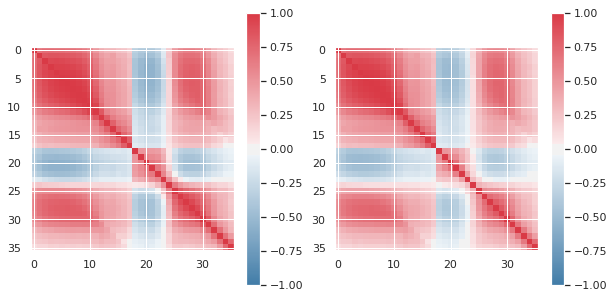

In [27]:
fig = plt.figure(figsize = (10, 5))
plt.subplot(121)
im = plt.imshow(corr[:36][:, :36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(122)
im = plt.imshow(full_corr[:36][:, :36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

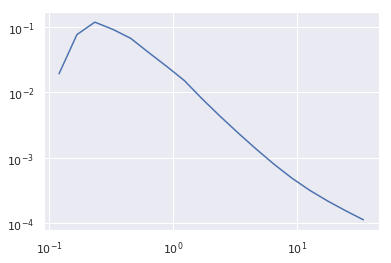

In [28]:
plt.plot(rp_points, np.diag(shape_noise_covmat))
plt.loglog();

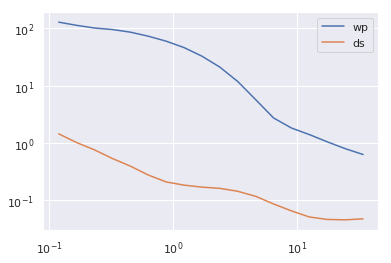

In [29]:
plt.plot(rp_points, np.sqrt(np.diag(full_cov[:18, :18]) ), label = 'wp')
#plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat) ), label = 'Shape')
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_cov[18:36, 18:36]) ), label = 'ds')

plt.loglog()
plt.legend(loc='best')

In [30]:
print  np.sqrt(np.diag(full_cov[18:36, 18:36]) )

[1.45016339 1.02231464 0.76216095 0.53865339 0.39734355 0.27796065
 0.21050301 0.18515866 0.17089616 0.16264145 0.14464581 0.1182107
 0.08697567 0.06582892 0.05156254 0.04665113 0.04600127 0.04778107]


In [31]:
#emu covs
emu_cov_fnames = ['/home/users/swmclau2/Git/pearce/bin/optimization/wp_hod_emu_cov.npy',
                  '/home/users/swmclau2/Git/pearce/bin/optimization/ds_hod_emu_cov.npy']

In [33]:
emu_cov = np.zeros_like(full_cov[:36][:, :36])

for i, fname in enumerate(emu_cov_fnames):
    
    emu_cov[i*18:(i+1)*18][:, i*18:(i+1)*18] = np.load(fname)

In [36]:
emu_corr = cov_to_corr(emu_cov)

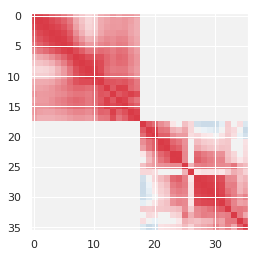

In [42]:
plt.imshow(emu_corr, cmap = cmap, vmin = -1)

In [38]:
full_emu_cov = full_cov[:36][:, :36] + emu_cov

In [39]:
full_emu_corr = cov_to_corr(full_emu_cov)

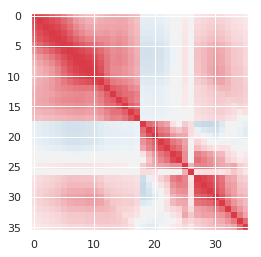

In [41]:
plt.imshow(full_emu_corr, cmap = cmap, vmin = -1)

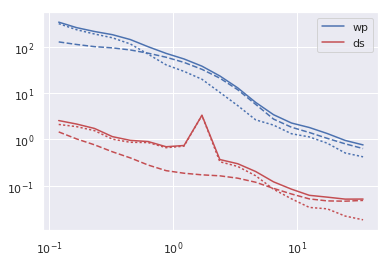

In [46]:
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[:18, :18]) ), label = 'wp', color = 'b')
plt.plot(rp_points, np.sqrt(np.diag(full_cov[:18, :18]) ), color = 'b', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[:18, :18]) ), color = 'b', ls = ':')


#plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat) ), label = 'Shape')
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36]) ), label = 'ds', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(full_cov[18:36, 18:36]) ), color = 'r', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')


plt.loglog()
plt.legend(loc='best')